In [3]:
# TOBIT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [20]:

def make_features(df: pd.DataFrame) -> pd.DataFrame:
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)
    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: np.sqrt((x.shift(1) ** 2)
                                       .rolling(window=30, min_periods=1).sum()))
    )

    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-60)   
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df = df.dropna(subset=['rv_future'])   
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [3]:


# 1) Load and feature‐engineer
df = pd.read_csv("/Users/tobitlouis/Desktop/Data/S27FE-10K.csv")
df = make_features(df)               # your function from above
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()                     # drop any row missing *any* feature or target

# 2) Define features & target
feature_cols = [
    'seconds_in_bucket', 'mid_price','spread',
    'imbalance','imbalance_lag1','imbalance_lag2',
    'book_pressure','book_pressure_lag1','book_pressure_lag2',
    'microprice','normalized_spread','OBI_L2',
    'LOB_entropy','LOB_entropy_normalized',
    'log_return','log_return_lag1','log_return_lag2',
    'bipower_var','wap','log_wap_return',
    'rolling_vol_30','rolling_imbalance_mean_30',
]
target_col = 'rv_future'

X = df[feature_cols].values
y = df[target_col].values  

# 3) Train/validation/test split
#    First split off test, then within train do CV
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) Scale features
scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled     = scaler.transform(X_test)

NameError: name 'make_features' is not defined

In [4]:
df = pd.read_parquet("/Users/tobitlouis/Desktop/Data/FE30Stocks.parquet")

In [5]:
feature_cols_mod = ['stock_id', 'mid_price', 'spread', 'imbalance',
       'book_pressure', 'LOB_entropy', 'log_return', 'bipower_var',
       'log_wap_return', 'imbalance_lag1', 'imbalance_lag2',
       'book_pressure_lag1', 'book_pressure_lag2', 'log_return_lag1',
       'log_return_lag2', 'rolling_vol_30', 'rolling_imbalance_mean_30',
       'sec_sin', 'sec_cos', 'bid_size1_log', 'ask_size1_log', 'bid_size2_log',
       'ask_size2_log']
target_col = "rv_future"

df['rv_future_log'] = np.log1p(df[target_col])
target_col_mod   = 'rv_future_log'

In [6]:

unique_sessions    = np.sort(df['time_id'].unique())
split_idx          = int(len(unique_sessions) * 0.8)

train_val_sessions = unique_sessions[:split_idx]
test_sessions      = unique_sessions[split_idx:]

train_val_df = df.loc[df['time_id'].isin(train_val_sessions)].copy()
test_df      = df.loc[df['time_id'].isin(test_sessions)].copy()

# ————————————————————————————————————————————————————————
# 2) FEATURE / TARGET ARRAYS
# ————————————————————————————————————————————————————————

# This replaces X_train / X_val / y_train / y_val
X_trainval = train_val_df[feature_cols_mod].values
y_trainval = train_val_df[target_col_mod].values.ravel()

X_test     = test_df[feature_cols_mod].values
y_test     = test_df[target_col_mod].values.ravel()

# ————————————————————————————————————————————————————————
# 3) SCALING
# ————————————————————————————————————————————————————————

# Fit scalers on train_val only
scaler_X = StandardScaler().fit(X_trainval)
scaler_y = StandardScaler().fit(y_trainval.reshape(-1,1))

X_trainval_scaled = scaler_X.transform(X_trainval)
# LassoCV in your snippet did NOT scale y, so we keep y_trainval unscaled
# If you *do* want to scale y, uncomment the next line:
# y_trainval = scaler_y.transform(y_trainval.reshape(-1,1)).ravel()

X_test_scaled = scaler_X.transform(X_test)

In [10]:


# 5) LassoCV (5-fold within trainval to pick alpha)
lasso_cv = LassoCV(
    alphas=np.logspace(-3, 1, 20),
    cv=3,                # fewer folds for speed
    n_jobs=-1,           
    max_iter=2000,
    tol=1e-3,
    random_state=42
)
lasso_cv.fit(X_trainval_scaled, y_trainval)

best_alpha = lasso_cv.alpha_
print(f"Best alpha from CV: {best_alpha:.5f}")

# 6) Evaluate on test set
y_pred = lasso_cv.predict(X_test_scaled)
mse_cv = mean_squared_error(y_test, y_pred)
r2_cv  = r2_score(y_test, y_pred)

def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual,   eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

# Compute QLIKE on your test set predictions
ql = qlike_safe(y_test, y_pred)

print("\nLassoCV Results on *test* set:")
print(f"  MSE: {mse_cv:.6f}")
print(f"  R²:  {r2_cv:.4f}")
print("QLIKE:", ql)


Best alpha from CV: 10.00000

LassoCV Results on *test* set:
  MSE: 0.000002
  R²:  -0.0000
QLIKE: 0.45682865


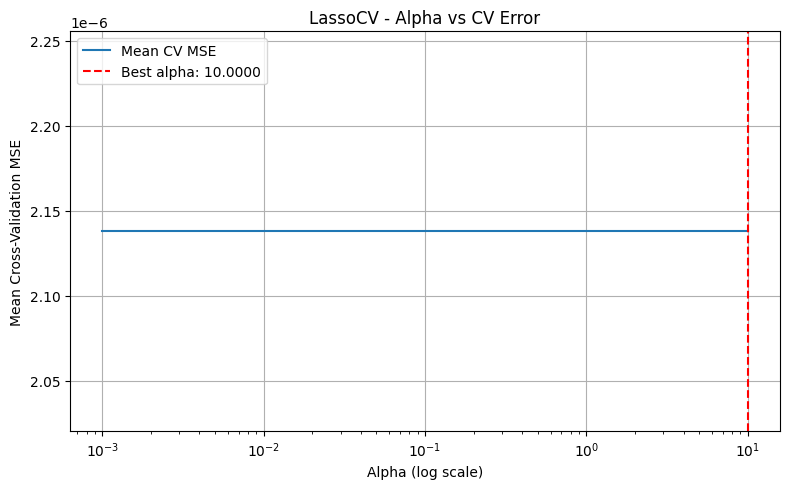

In [11]:
# Cross-Validation and MSE vs Alpha 
plt.figure(figsize=(8, 5))
plt.semilogx(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), label='Mean CV MSE')
plt.axvline(best_alpha, linestyle='--', color='red', label=f'Best alpha: {best_alpha:.4f}')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Mean Cross-Validation MSE")
plt.title("LassoCV - Alpha vs CV Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


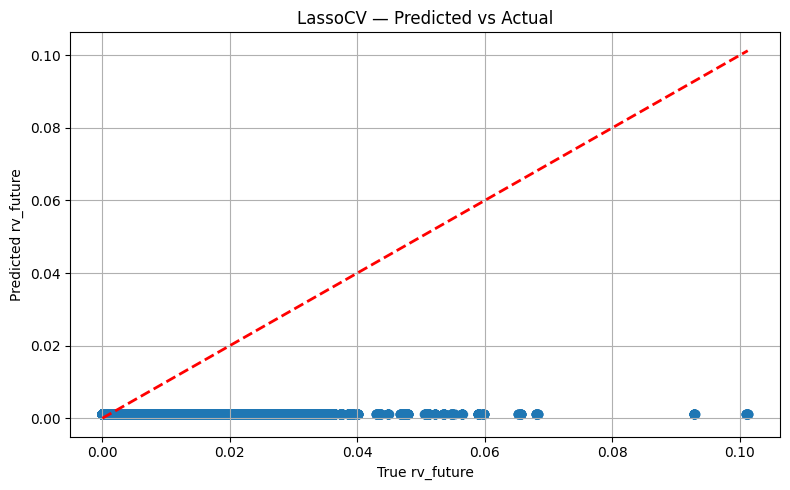

In [12]:
import matplotlib.pyplot as plt

# True vs Predicted Volatility
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', lw=2
)
plt.xlabel("True rv_future")
plt.ylabel("Predicted rv_future")
plt.title("LassoCV — Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()



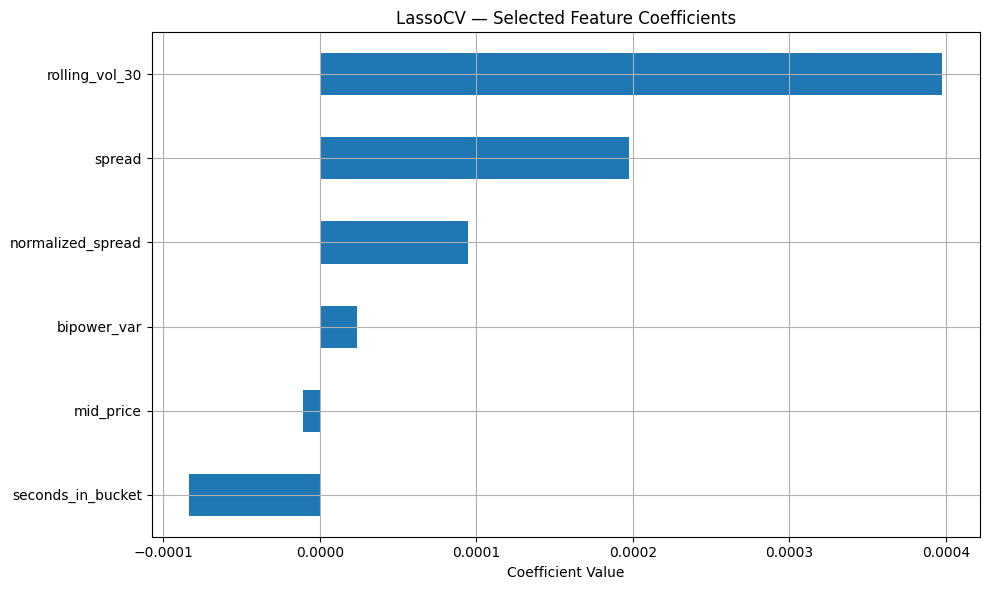

In [24]:
coefs = pd.Series(lasso_cv.coef_, index=feature_cols)
nonzero_coefs = coefs.loc[coefs != 0]

plt.figure(figsize=(10, 6))
nonzero_coefs.sort_values().plot(kind='barh')
plt.title("LassoCV — Selected Feature Coefficients")
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()